In [1]:
import cv2
import numpy as np
from tensorflow.keras.layers import * 
from tensorflow.keras.models import * 
from tensorflow.keras.optimizers import * 
from tensorflow.keras.losses import * 
from tensorflow.keras.metrics import * 
from tensorflow.keras.losses import * 
import tensorflow as tf
from tensorflow.keras.callbacks import *
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import math
import warnings
import glob
from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings("ignore")

2025-09-02 16:09:12.855676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756829353.028869      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756829353.079459      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def augmentations(img):
    images = []

    # --- Original ---
    images.append(img)

    # --- Flips ---
    images.append(cv2.flip(img, 1))  # Horizontal
    
    images.append(cv2.flip(img, 0))  # Vertical

    # --- Rotations ---
    images.append(cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE))

    images.append(cv2.rotate(img, cv2.ROTATE_180))

    images.append(cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))

    # --- Gaussian Blur ---
    images.append(cv2.GaussianBlur(img, (5, 5), 0))

    # --- Additive Gaussian Noise ---
    noise = np.random.normal(0, 25, img.shape).astype(np.uint8)  # sigma=25, adjust as needed
    noisy_img = cv2.add(img, noise)
    images.append(noisy_img)

    # --- Brightness Increase ---
    bright_img = cv2.convertScaleAbs(img, alpha=1.0, beta=50)  # beta >0 increases brightness
    images.append(bright_img)

    # --- Brightness Decrease ---
    dark_img = cv2.convertScaleAbs(img, alpha=1.0, beta=-50)  # beta <0 decreases brightness
    images.append(dark_img)

    # --- Cropping ---
    h, w, c = img.shape
    img_crop = img[w//3:(2*w//3), h//3:(2*h//3)]
    images.append(img_crop)
    return images

def load(path, classes, aug=False):
    X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []

    for i, cls in enumerate(classes):
        files = [f for f in os.listdir(os.path.join(path, cls)) if "mask" not in f]

        # Split per class
        train_files, val_files = train_test_split(files, test_size=0.15, shuffle=True, random_state=42)
        train_files, test_files = train_test_split(train_files, test_size=0.15, shuffle=True, random_state=42)

        for f in tqdm(files):
            try:
                img = cv2.imread(os.path.join(path, cls, f))

                # --- TRAIN (with optional augmentation) ---
                if f in train_files:
                    if aug:
                        images= augmentations(img)
                    else:
                        images = [img]

                    for im in images:
                        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                        im = cv2.resize(im, (128, 128)) / 255.
                        X_train.append(np.expand_dims(im, -1))

                        y_train.append([0, 1, 0] if cls == "benign" else [0, 0, 1] if cls == "malignant" else [1, 0, 0])

                # --- VAL (no augmentation) ---
                elif f in val_files:
                    im = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    im = cv2.resize(im, (128, 128)) / 255.
                    X_val.append(np.expand_dims(im, -1))

                    y_val.append([0, 1, 0] if cls == "benign" else [0, 0, 1] if cls == "malignant" else [1, 0, 0])

                # --- TEST (no augmentation) ---
                elif f in test_files:
                    im = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    im = cv2.resize(im, (128, 128)) / 255.
                    X_test.append(np.expand_dims(im, -1))

                    y_test.append([0, 1, 0] if cls == "benign" else [0, 0, 1] if cls == "malignant" else [1, 0, 0])

            except Exception as e:
                print(f"Skipping {f} due to error: {e}")

    return (
        np.array(X_train), np.array(y_train),
        np.array(X_val), np.array(y_val),
        np.array(X_test), np.array(y_test)
    )


In [3]:
train_images, train_labels, val_images, val_labels, test_images, test_labels = load("/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT", classes=["benign", "malignant", "normal"], aug=True)

100%|██████████| 133/133 [00:06<00:00, 20.68it/s]


In [4]:
print(f"NUMBER OF TRAIN SAMPLES : {train_images.shape[0]}\nNUMBER OF VALIDATION SAMPLES : {val_images.shape[0]}\nNUMBER OF TEST SAMPLES : {test_images.shape[0]}")

NUMBER OF TRAIN SAMPLES : 6182
NUMBER OF VALIDATION SAMPLES : 118
NUMBER OF TEST SAMPLES : 100


In [27]:
inv_cts = np.array([
    1 / (len(os.listdir(os.path.join("/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT", cls))) / 2)
    for cls in ["normal", "benign", "malignant"]
])

inv_cts = inv_cts / inv_cts.sum()
print("Normalized inverse counts:", inv_cts)

weights = {k: v for k, v in enumerate(inv_cts)}
print("Weights dictionary:", weights)

Normalized inverse counts: [0.51803542 0.15465479 0.32730979]
Weights dictionary: {0: 0.5180354176132401, 1: 0.15465479358599538, 2: 0.32730978880076456}


In [28]:
class SqueezeExcite(Layer):
    def __init__(self, ratio=16, **kwargs):
        super(SqueezeExcite, self).__init__(**kwargs)
        self.ratio = ratio
        self.gap = GlobalAveragePooling2D()

    def build(self, input_shape):
        filters = input_shape[-1]
        self.dense1 = Dense(filters // self.ratio, activation='relu')
        self.dense2 = Dense(filters, activation='sigmoid')
        self.reshape = Reshape((1, 1, filters))
        self.multiply = Multiply()
        super(SqueezeExcite, self).build(input_shape)

    def call(self, inputs):
        se = self.gap(inputs)
        se = self.dense1(se)
        se = self.dense2(se)
        se = self.reshape(se)
        return self.multiply([inputs, se])

    def get_config(self):
        config = super(SqueezeExcite, self).get_config()
        config.update({"ratio": self.ratio})
        return config

In [58]:
inputs = Input((128, 128, 1), name="Input")

x = Conv2D(64, (3,3), activation='relu', padding='same', name="Conv1")(inputs)
x = MaxPooling2D(name="Pool1")(x)
x = BatchNormalization(name="BN1")(x)

x = Conv2D(128, (3,3), activation='relu', padding='same', name="Conv2")(x)
x = MaxPooling2D(name="Pool2")(x)
x = BatchNormalization(name="BN2")(x)

x = Conv2D(256, (3,3), activation='relu', padding='same', name="Conv3")(x)
x = SqueezeExcite(name="SE")(x)

x = GlobalMaxPooling2D(name="GAP")(x)
x = Dropout(0.5, name="Dropout1")(x)
x = Dense(128, activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(1e-4),
          name="Dense1")(x)
x = Dropout(0.5, name="Dropout2")(x)
outputs = Dense(3, activation='softmax', name="Output")(x)

model = Model(inputs=inputs, outputs=outputs, name="CNN_SE_Model")
model.summary()

Model: "CNN_SE_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN1 (BatchNormalization)        │ (None, 64, 64, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN2 (BatchNormalization)        │ (None, 32, 32, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ SE (SqueezeExcite)              │ (None, 32, 32, 256)    │         8,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GAP (GlobalMaxPooling2D)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout2 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 412,179 (1.57 MB)

 Trainable params: 411,795 (1.57 MB)

 Non-trainable params: 384 (1.50 KB)

In [59]:
model.compile(optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), loss=CategoricalFocalCrossentropy(), metrics=[Recall(name="recall"), Precision(name="precision"),
                  AUC(name='prauc', curve='PR'), AUC(name='auroc', curve='ROC'), "accuracy"])

In [60]:
!mkdir models
chkp = tf.keras.callbacks.ModelCheckpoint(
    "/kaggle/working/models/model.keras",
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    initial_value_threshold=None,
)
reducelr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=3,
    mode="max",
    min_lr=1e-6,
)

mkdir: cannot create directory ‘models’: File exists


In [61]:
history = model.fit(train_images, train_labels, batch_size=32, epochs=50, validation_data=(val_images, val_labels), callbacks=[chkp, reducelr], class_weight=weights)

Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.3440 - auroc: 0.5227 - loss: 0.0768 - prauc: 0.3517 - precision: 0.3589 - recall: 0.1848 - val_accuracy: 0.1525 - val_auroc: 0.3516 - val_loss: 0.1433 - val_prauc: 0.2612 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3036 - auroc: 0.4835 - loss: 0.0484 - prauc: 0.3260 - precision: 0.3557 - recall: 0.0098 - val_accuracy: 0.1695 - val_auroc: 0.3051 - val_loss: 0.1377 - val_prauc: 0.2422 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.2993 - auroc: 0.4771 - loss: 0.0460 - prauc: 0.3300 - precision: 0.4470 - recall: 0.0031 - val_accuracy: 0.5508 - val_auroc: 0.7114 - val_loss: 0.1309 - val_prauc: 0.5734 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step -

In [63]:
model.evaluate(test_images, test_labels)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step - accuracy: 0.7582 - auroc: 0.8873 - loss: 0.0907 - prauc: 0.8292 - precision: 0.8005 - recall: 0.7481


[0.11512990295886993,
 0.7400000095367432,
 0.7956989407539368,
 0.8300132751464844,
 0.8816999793052673,
 0.7599999904632568]

In [64]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


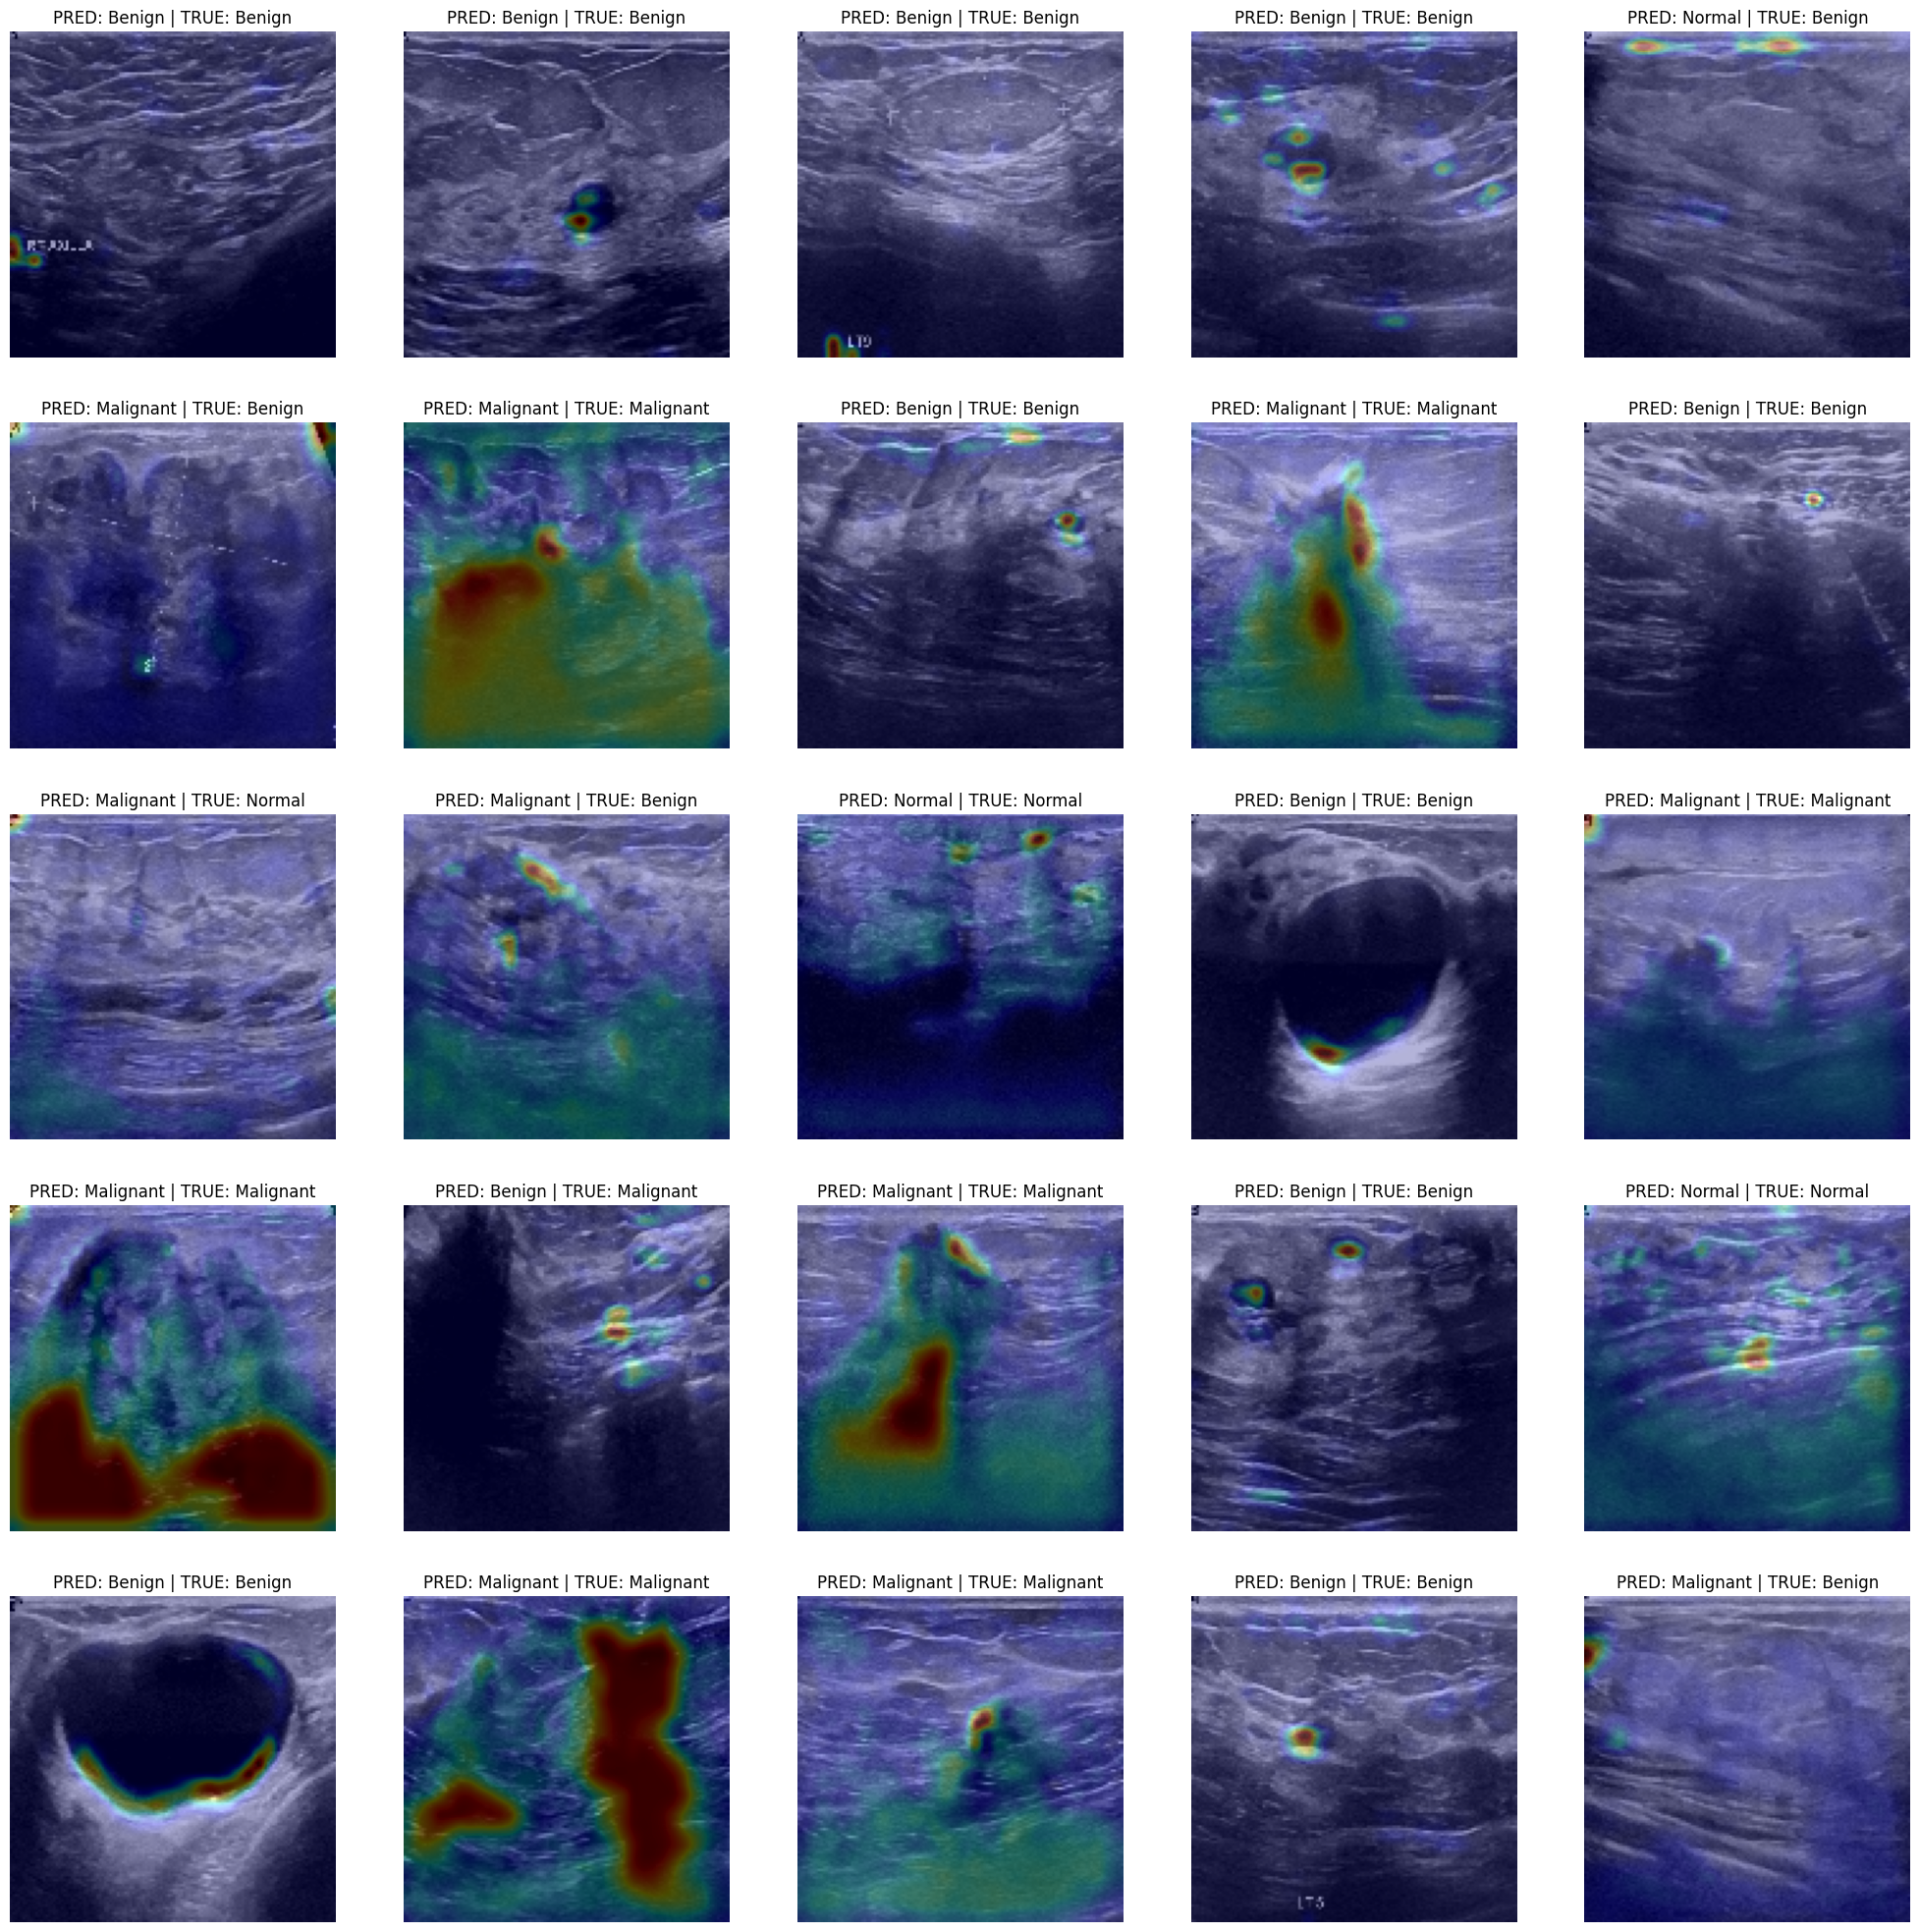

In [80]:
class_names = ["Normal", "Benign", "Malignant"]
preds = model.predict(test_images)
idxs = np.random.choice(len(test_images), size=25, replace=False)
plt.figure(figsize=(25, 25))

for i, idx in enumerate(idxs):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[idx], cmap="gray")

    gradcam = make_gradcam_heatmap(
        np.expand_dims(test_images[idx], axis=0),
        model,
        "SE"
    )
    gradcam = tf.image.resize(gradcam[..., tf.newaxis], test_images[idx].shape[:2]).numpy().squeeze()
    gradcam = cv2.blur(gradcam, (3, 3))
    gradcam = gradcam / gradcam.max()  

    plt.imshow(gradcam, cmap="jet", alpha=0.3)

    class_id = np.argmax(test_labels[idx])
    pred_id = np.argmax(preds[idx])
    plt.title(f'PRED: {class_names[pred_id]} | TRUE: {class_names[class_id]}')
    plt.axis("off")
plt.savefig(f"results.png")


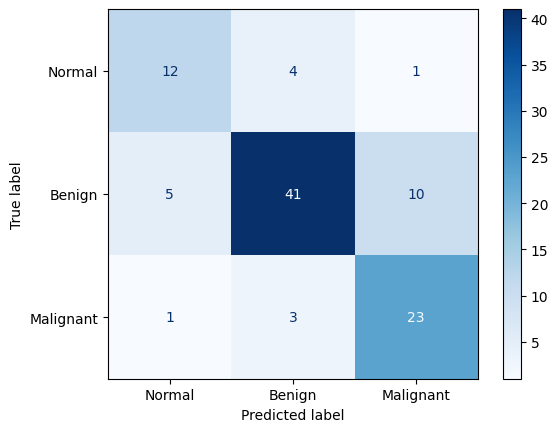

In [79]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true_classes = np.argmax(test_labels, axis=1)
y_pred_classes = np.argmax(preds, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Normal", "Benign", "Malignant"])
disp.plot(cmap="Blues", values_format="d")
plt.savefig("breastcm.png")